In [1]:
import awkward as ak
import numpy as np
import hist
from coffea import processor, hist as chist
from coffea.nanoevents.methods import vector
import uproot
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.lookup_tools import extractor
import mplhep as hep
import matplotlib.pyplot as plt
import numba

In [47]:
class MyProcessor(processor.ProcessorABC):
    def process(self, events):
        #dimensions of cms and muon subdetector region
        dim = {
            'csc':{},
            'dt':{},
            'cms':{},
        }

        s = 1e2 #cm
        dim['csc']['zmin'] = s * 5.5
        dim['csc']['zmax'] = s * 10.
        dim['csc']['rmin'] = s * 0.
        dim['csc']['rmax'] = s * 7.
        dim['dt']['zmin'] = s * 0.
        dim['dt']['zmax'] = s * 6.5
        dim['dt']['rmin'] = s * 4.
        dim['dt']['rmax'] = s * 7.5
        
        dim['cms']['zmin'] = s * 0.
        dim['cms']['zmax'] = s * 12.
        dim['cms']['rmin'] = s * 0.
        dim['cms']['rmax'] = s * 8.
        
        
        dataset = events.metadata['dataset']
        sumw = ak.sum(events.genWeight)

        out = {
                dataset: {
                            "entries": len(events),
                            "sumw": sumw,
                         }
              }
        
        def R(x, y):
            return np.sqrt(x**2 + y**2)
        
        #this is a dirty way of doing this
        if ak.any(events.gParticleId == 9900015): pid = 9900015
        if ak.any(events.gParticleId == 1000023): pid = 1000023            
        
        #makes mask of particles who's parent is an LLP
        llpPIDmomCut = (events.gParticleMotherId == pid)
        #takes care of multi counting by picking index of first True value in each column
        llpDaughterInd = ak.argmax(llpPIDmomCut, axis = 1, keepdims = True)
        llpMomInd = events.gParticleMotherIndex[llpDaughterInd]
        #llpMomInd = (events.gParticleId == 1000023)
        
        llps = ak.zip(
                        {
                            'X': events.gParticleProdVertexX[llpDaughterInd],
                            'Y': events.gParticleProdVertexY[llpDaughterInd],
                            'Z': events.gParticleProdVertexZ[llpDaughterInd], 
                            'R': R(events.gParticleProdVertexX[llpDaughterInd],
                                   events.gParticleProdVertexY[llpDaughterInd]),
                            'pt': events.gParticlePt[llpMomInd],
                            'phi': events.gParticlePhi[llpMomInd],
                            'eta': events.gParticleEta[llpMomInd],
                            'mass': ak.ones_like(events.gParticlePhi[llpMomInd]),
                            'E': events.gParticleE[llpMomInd],
                        },
                        with_name = 'PtEtaPhiMLorentzVector',
                        behavior = vector.behavior,                 
                      )

        cscs = ak.zip(
                        {
                            'X': events.cscRechitClusterX,
                            'Y': events.cscRechitClusterY,
                            'Z': events.cscRechitClusterZ, 
                            'R': R(events.cscRechitClusterX, events.cscRechitClusterY),
                            'pt': ak.ones_like(events.cscRechitClusterPhi),
                            'phi': events.cscRechitClusterPhi,
                            'eta': events.cscRechitClusterEta,
                            'mass': ak.ones_like(events.cscRechitClusterPhi),
                        },
                        with_name = 'PtEtaPhiMLorentzVector',
                        behavior = vector.behavior,                 
                      )

        dts = ak.zip(
                        {
                            'X': events.dtRechitClusterX,
                            'Y': events.dtRechitClusterY,
                            'Z': events.dtRechitClusterZ, 
                            'R': R(events.dtRechitClusterX, events.dtRechitClusterY),
                            'pt': ak.ones_like(events.dtRechitClusterPhi),
                            'phi': events.dtRechitClusterPhi,
                            'eta': events.dtRechitClusterEta,
                            'mass': ak.ones_like(events.dtRechitClusterPhi),
                        },
                        with_name = 'PtEtaPhiMLorentzVector',
                        behavior = vector.behavior,                 
                      )
        
        def cscCutter(p):
            cut = (
                    (abs(p.eta) < 2.4) & 
                    (abs(p.Z) > dim['csc']['zmin']) & (abs(p.Z) < dim['csc']['zmax']) &
                    (p.R < dim['csc']['rmax'])
                  )
            return p[cut]
        
        def dtCutter(p):
            cut = (
                    (p.R > dim['dt']['rmin']) & (p.R < dim['dt']['rmax']) &
                    (abs(p.Z) < dim['dt']['zmax'])
                  )
            return p[cut]
        
        llpcscs = cscCutter(llps)
        cscs = cscCutter(cscs)
        
        llpdts = dtCutter(llps)
        dts = dtCutter(dts)
        
        #hist initializer
        def geo_hister(bins, region):
            return (
                    hist.Hist.new
                    .Reg(bins, dim[region]['zmin'], dim[region]['zmax'], name = 'z', label="z decay pos [cm]")
                    .Reg(bins, dim[region]['rmin'], dim[region]['rmax'], name = 'r', label="r decay pos [cm]")
                    .Double()
                   )
        
        bins = 30
        out[dataset]['genLLP'] = geo_hister(bins, region = 'cms')
        
        out[dataset]['genCSC'] = geo_hister(bins, region = 'cms')
        out[dataset]['genDT'] = geo_hister(bins, region = 'cms')

        out[dataset]['clsCSC'] = geo_hister(bins, region = 'cms')
        out[dataset]['clsDT'] = geo_hister(bins, region = 'cms')
        
        out[dataset]['clsCSC_dRcut'] = geo_hister(bins, region = 'cms')
        out[dataset]['clsDT_dRcut'] = geo_hister(bins, region = 'cms')
        
        def hister(bins, region, name, label):
            return (
                    hist.Hist.new
                    .Reg(bins, region[0], region[1], name = name, label = label)
                    .Double()
                   )            

        out[dataset]['dRCSC'] = hister(bins, [0,1], 'dR', 'dR')
        out[dataset]['dRDT'] = hister(bins, [0,1], 'dR', 'dR')
        
        out[dataset]['ptCSC'] = hister(bins, [0,100], 'pt', 'pt [GeV]')
        out[dataset]['ptDT'] = hister(bins, [0,100], 'pt', 'pt [GeV]')
        
        out[dataset]['ECSC'] = hister(bins, [0,100], 'E', 'E [GeV]')
        out[dataset]['EDT'] = hister(bins, [0,100], 'E', 'E [GeV]')
        
        #hist filler
        def geo_filler(hist, p):
            z = abs(ak.flatten(p.Z, axis = None))
            r = ak.flatten(p.R, axis = None)
            hist.fill(z = z, r = r)
            
        def geo_filler_dRcut_helper(llps, clusts):
            clust_llp_pairs = ak.cartesian({"clusts": clusts, "llps": llps}, axis = 1, nested = True)
            delta_R = (clust_llp_pairs.clusts).delta_r(clust_llp_pairs.llps)
            matched = clust_llp_pairs.clusts[delta_R < 0.3]
            return abs(ak.flatten(matched.Z, None)), ak.flatten(matched.R, None), delta_R
            
        def geo_filler_dRcut(hist2d, hist1d, llps, clusts):
            z, r, dR = geo_filler_dRcut_helper(llps, clusts)
            hist2d.fill(z = z, r = r)
            hist1d.fill(dR = ak.flatten(dR, None))

        def pt_filler(hist, p):
            hist.fill(ak.flatten(p.pt, None))
                  
        def E_filler(hist, p):
            hist.fill(ak.flatten(p.E, None))            
            
        geo_filler(out[dataset]['genLLP'], llps)
        geo_filler(out[dataset]['genCSC'], llpcscs)
        geo_filler(out[dataset]['genDT'], llpdts)
        geo_filler(out[dataset]['clsCSC'], cscs)
        geo_filler(out[dataset]['clsDT'], dts)
        
        geo_filler_dRcut(out[dataset]['clsCSC_dRcut'], out[dataset]['dRCSC'], llpcscs, cscs)
        geo_filler_dRcut(out[dataset]['clsDT_dRcut'], out[dataset]['dRDT'], llpdts, dts)
        
        pt_filler(out[dataset]['ptCSC'], llpcscs)
        pt_filler(out[dataset]['ptDT'], llpdts)
        
        E_filler(out[dataset]['ECSC'], llpcscs)
        E_filler(out[dataset]['EDT'], llpdts)
        
        return out

    def postprocess(self, accumulator):
        return accumulator

#digging up 
def rootAdds(directory):
    my_file = open(directory, "r")
    data = my_file.read().strip()
    data_into_list = data.split("\n")
    my_file.close()
    return data_into_list

In [48]:
fileset = {}
fileset['hnl'] = rootAdds('rootAdds/BToHNL_MuonAndHNLGenFilter_mHNL1p0_ctau1000.txt')
fileset['phi'] = rootAdds('rootAdds/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000.txt')

out = processor.run_uproot_job(
    fileset,
    treename = "ntuples/llp",
    processor_instance = MyProcessor(),
    executor = processor.futures_executor,
    executor_args = {"schema": BaseSchema, "workers": 6},
    maxchunks = 30,
)

out

Preprocessing:   0%|          | 0/219 [00:00<?, ?file/s]

Processing:   0%|          | 0/60 [00:00<?, ?chunk/s]

[0.614, 0.851, 1, 1.03, 1.07, 1.2, 1.21, ... 10, 10.3, 12.1, 13.3, 14.8, 15.1, 16.2]
[0.701, 1.31, 1.45, 1.61, 1.71, 2.02, 2.05, ... 14, 14.2, 16.1, 16.9, 17.3, 21.5]
[0.445, 0.493, 0.814, 0.852, 0.869, 0.945, ... 13.2, 13.2, 14.1, 14.2, 14.5, 35.4]
[1.15, 1.37, 1.38, 1.4, 1.53, 1.54, 1.58, ... 15, 17.4, 19.1, 19.4, 20.1, 29.1, 44]
[0.643, 0.73, 0.879, 1, 1.08, 1.11, 1.15, ... 11.5, 12, 13.6, 14.6, 15.2, 16.9, 21.7]
[1.13, 1.53, 1.62, 1.69, 1.73, 1.74, 1.84, ... 12.4, 12.5, 13.4, 15.2, 23.2, 47]
[0.639, 0.68, 0.684, 0.739, 0.8, 0.818, ... 13.1, 17.1, 17.3, 17.7, 18.4, 26.6]
[0.911, 1.01, 1.32, 1.33, 1.71, 1.79, 1.8, ... 15, 15.7, 17.1, 18.4, 18.5, 19.3]
[0.742, 0.822, 0.867, 0.961, 0.974, 1.08, ... 14.4, 14.7, 14.8, 20.9, 22.5, 116]
[1.65, 1.77, 1.78, 1.79, 1.79, 1.82, 1.86, ... 12.7, 13.1, 13.2, 13.6, 19.1, 28.2]
[0.53, 0.564, 0.576, 0.628, 0.983, 1.01, 1.03, ... 17.2, 18, 18.1, 21.8, 25.9, 26.4]
[0.983, 1.11, 1.16, 1.31, 1.43, 1.54, 1.6, ... 15.1, 15.9, 16.5, 16.8, 19.4, 21.8]
[0.779

[0.897, 1.57, 1.67, 1.92, 2.08, 2.88, 4.4, ... 6.7, 7.36, 8.06, 9.18, 9.55, 11.3]
[1.63, 2.74, 3.44, 3.72, 4.31, 4.95, 5.56, ... 9.18, 9.38, 11.4, 12.1, 12.1, 17.1]
[0.518, 1.25, 1.34, 1.53, 1.62, 1.71, 1.88, ... 5.63, 5.78, 6.05, 7.44, 8.68, 16.3]
[1.37, 1.5, 1.53, 1.56, 2.18, 3.17, 6.05, 6.69, 7.78, 8.68, 10.1, 16.3]
[0.966, 1.23, 1.86, 1.98, 2.18, 2.9, 2.92, ... 5.49, 5.99, 6.29, 7.18, 8.49, 35.2]
[1.41, 2.1, 2.15, 2.3, 3.04, 3.41, 4.82, ... 6.19, 6.68, 6.82, 7.18, 7.3, 7.4, 12.3]
[0.932, 1.02, 1.81, 1.84, 1.87, 2.01, 2.14, ... 5.25, 6.86, 6.89, 6.93, 7.11, 13.9]
[1.7, 1.89, 1.95, 2.33, 2.71, 2.98, 4.02, ... 5.49, 5.53, 6.86, 6.93, 8.11, 8.58]
[1.32, 1.91, 3.63, 4, 4.07, 4.39, 5.91, ... 6.58, 6.75, 7.57, 7.65, 9.22, 10.7, 11.6]
[2.57, 3.34, 5.27, 5.78, 6, 6.75, 7.11, 7.79, 12.4, 15.1, 15.9]
[0.832, 1.09, 1.68, 1.86, 2.27, 3.13, 4.98, ... 7.19, 7.5, 7.65, 7.7, 9.15, 9.67]
[1.39, 1.59, 1.65, 1.68, 1.88, 2.15, 2.79, ... 5.66, 6.15, 6.45, 6.59, 7.59, 17.9]
[1.01, 1.12, 1.4, 1.43, 1.45, 

{'phi': {'genCSC': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 5946.0,
  'ptCSC': Hist(Regular(30, 0, 100, name='pt', label='pt [GeV]'), storage=Double()) # Sum: 5945.0 (5946.0 with flow),
  'clsCSC': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 5784.0,
  'genLLP': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 58269.0 (104432.0 with flow),
  'clsDT_dRcut': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 2.0,
  'entries': 104432,
  'sumw': 104432.0,
  'genDT': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 

/tmp/ipykernel_30743/4008535251.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


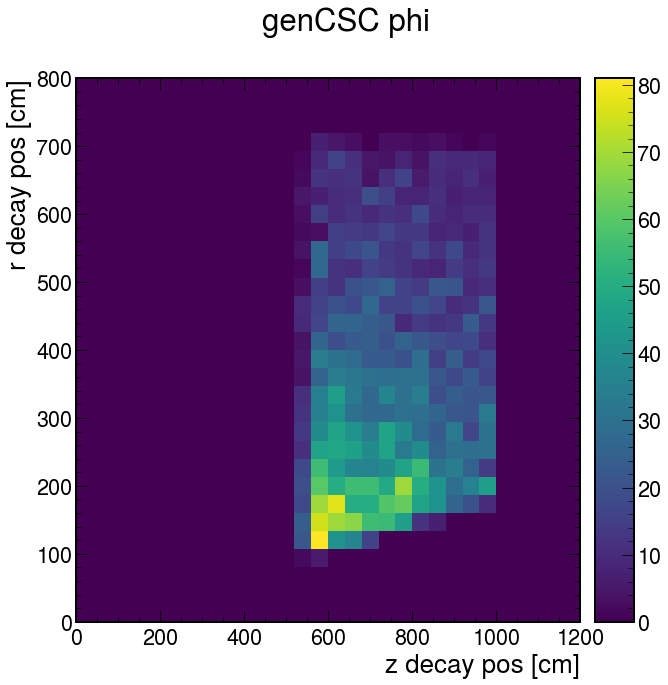

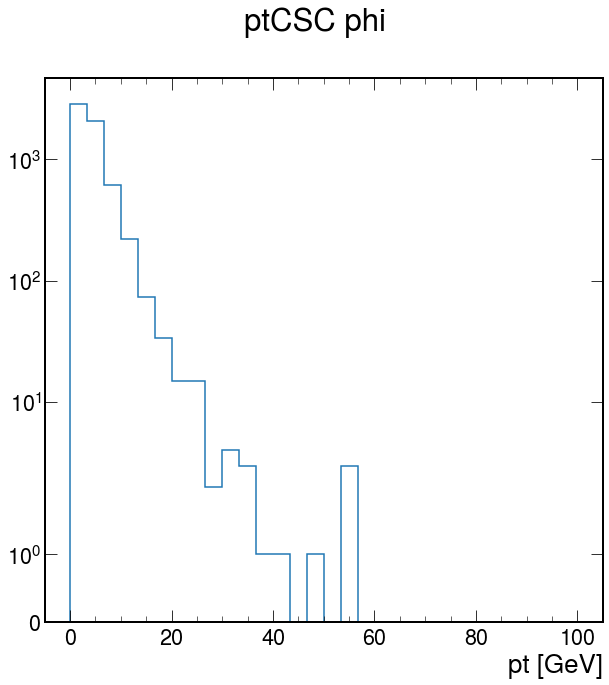

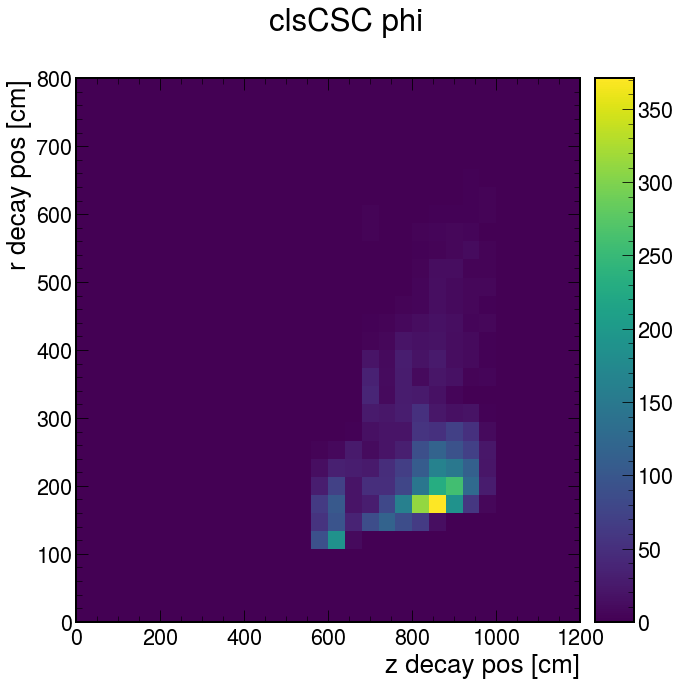

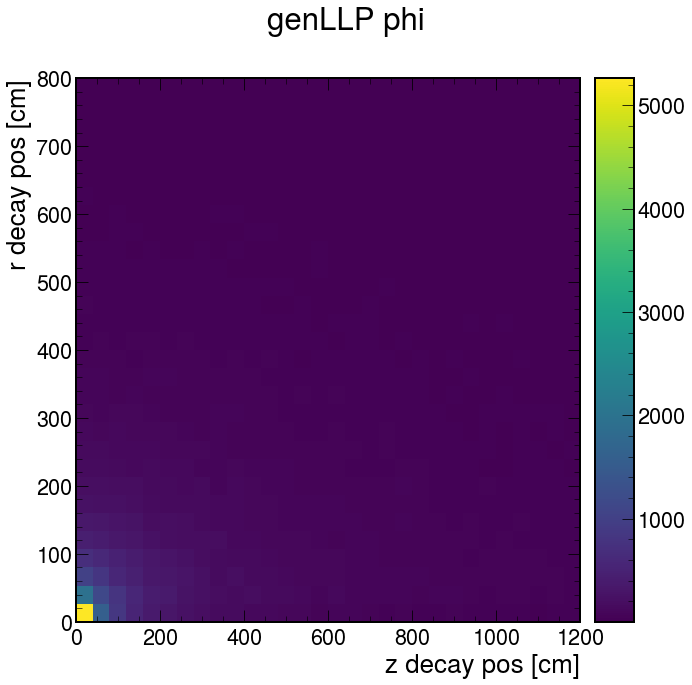

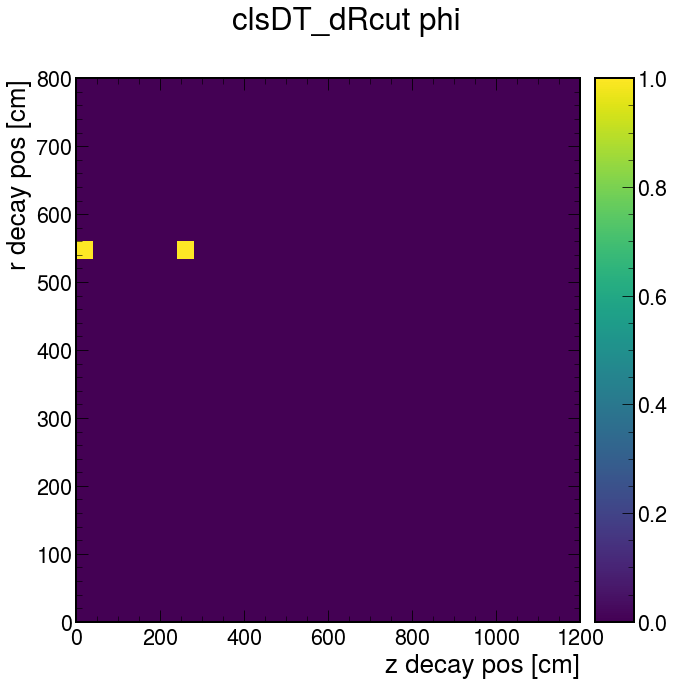

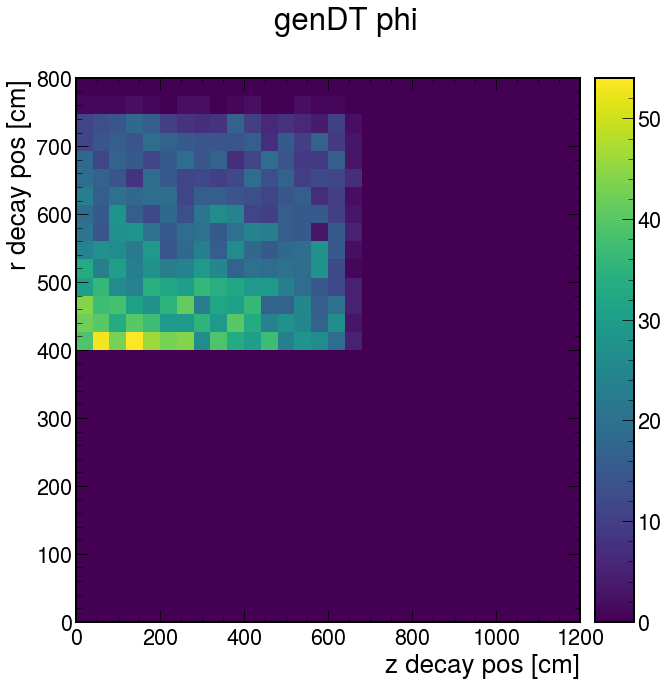

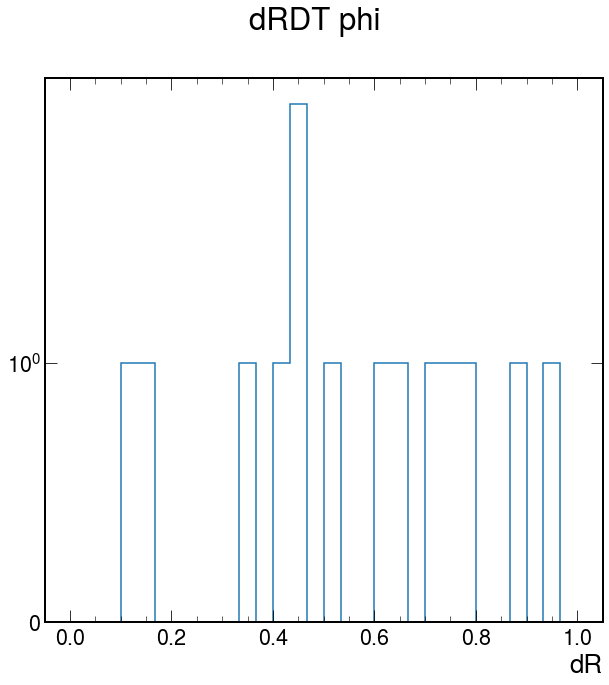

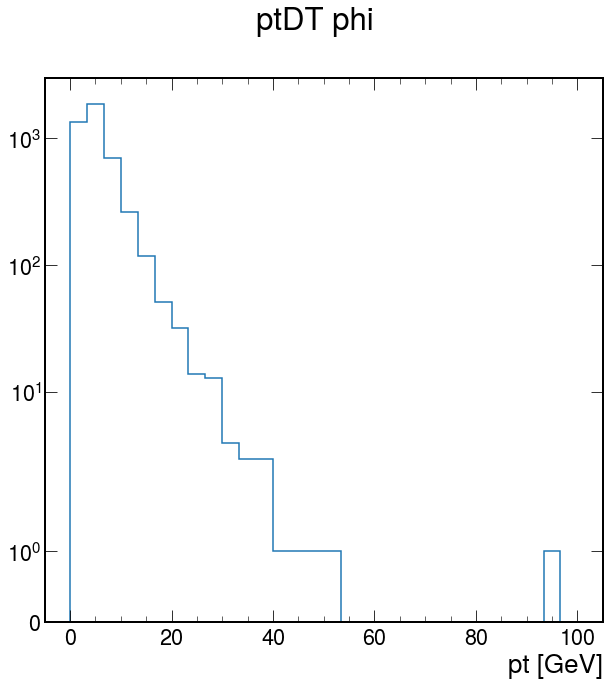

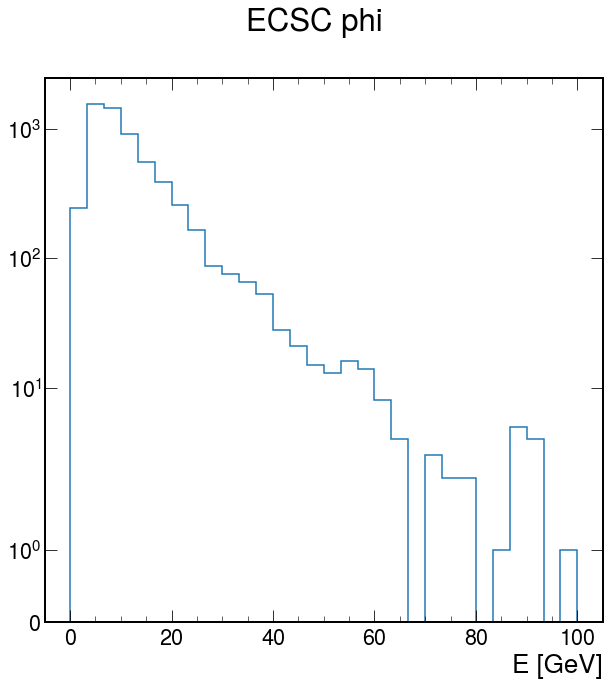

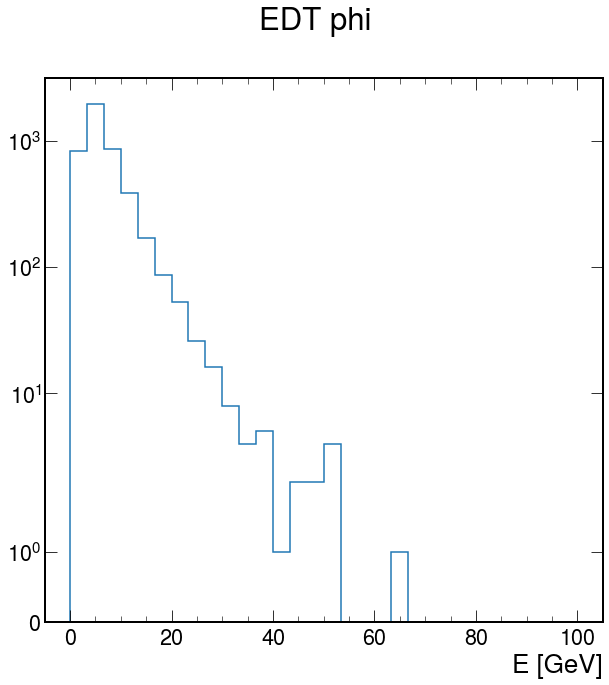

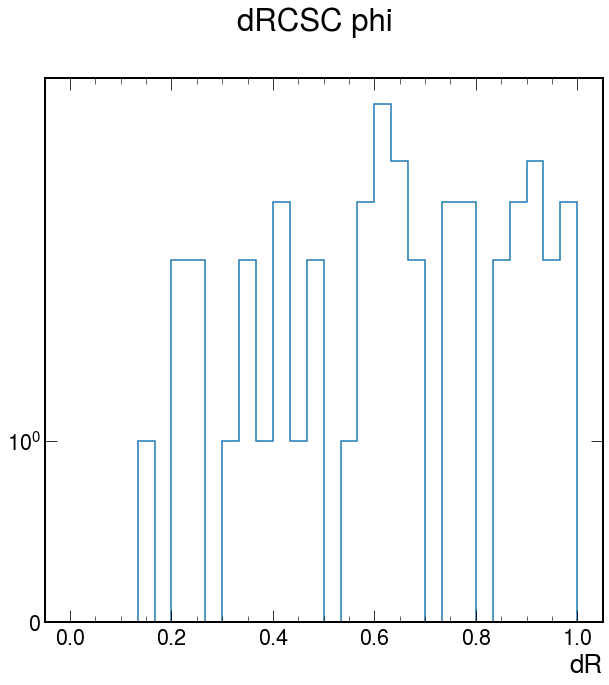

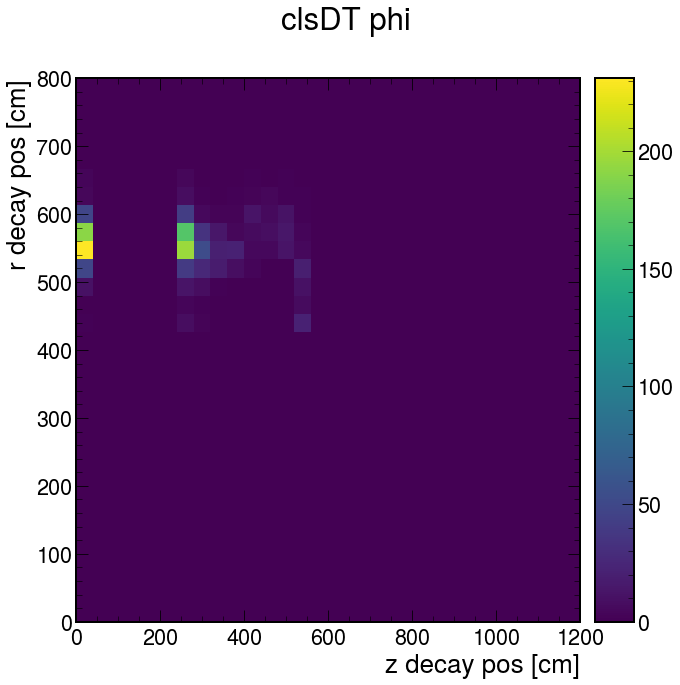

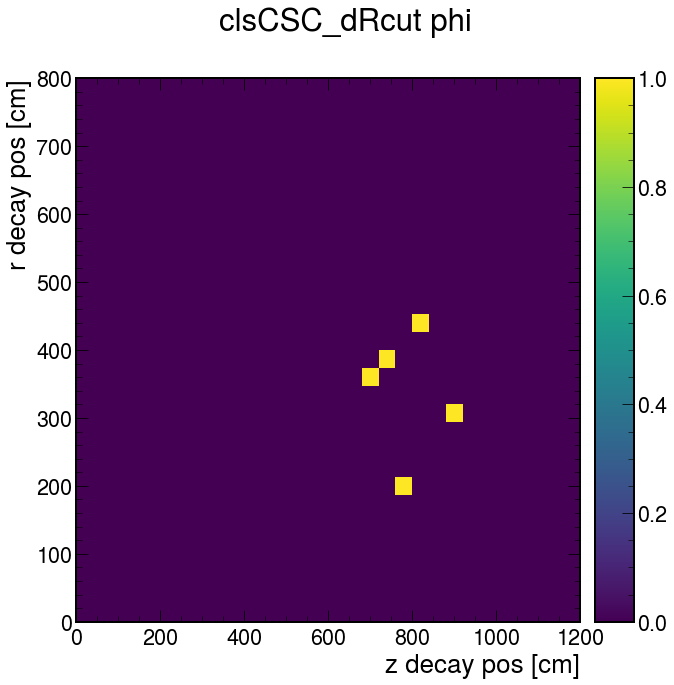

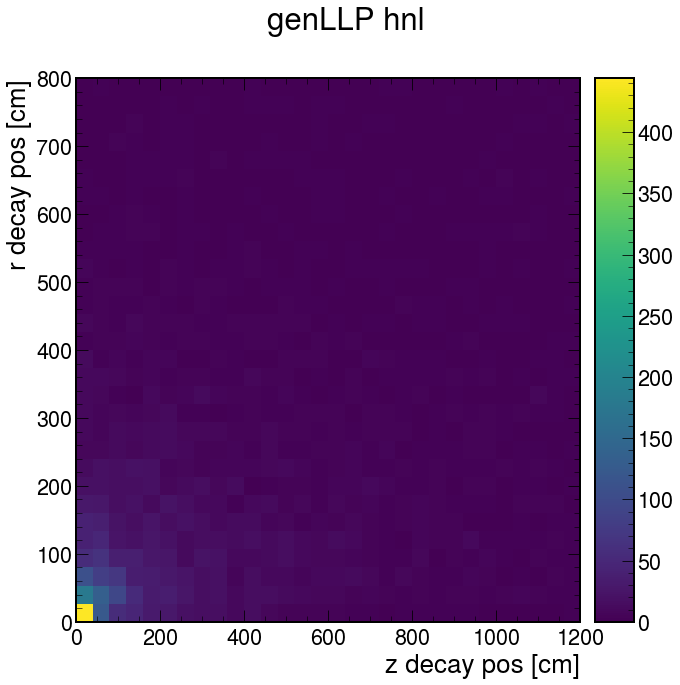

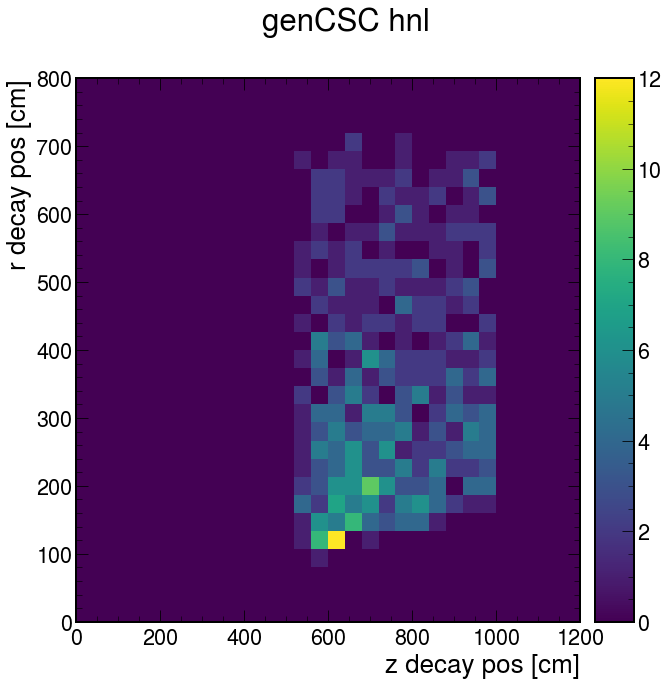

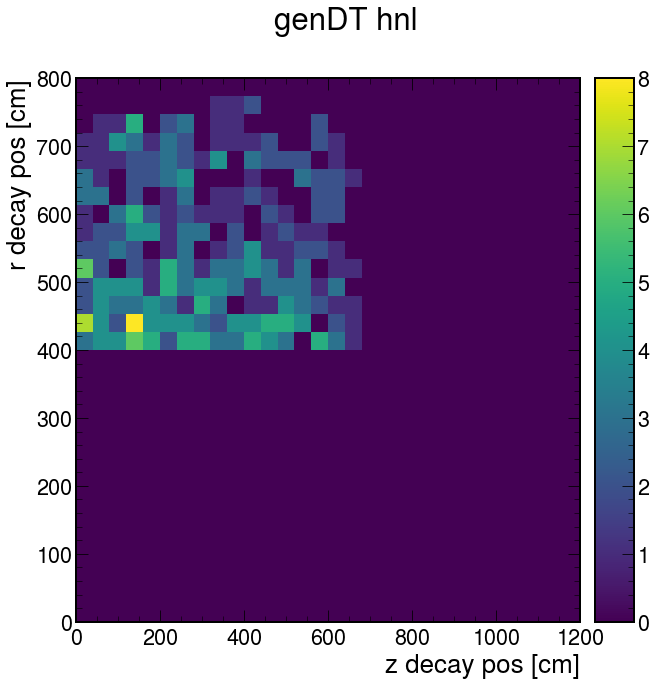

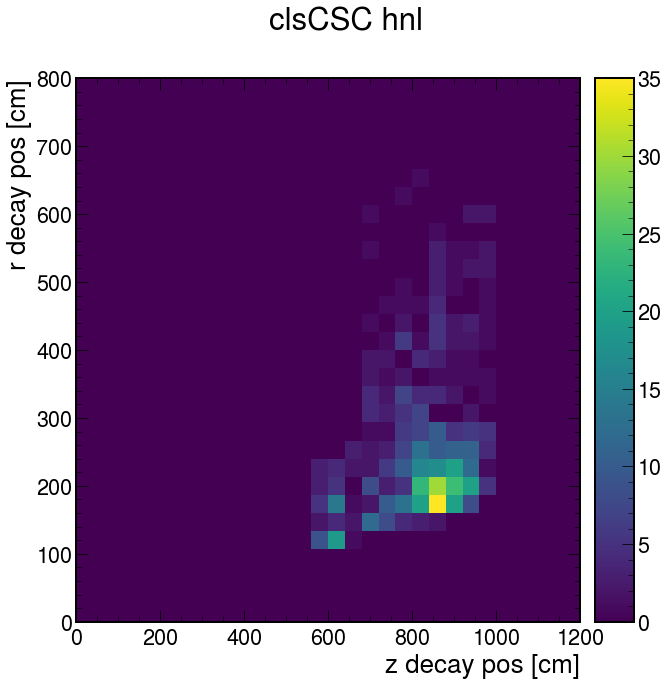

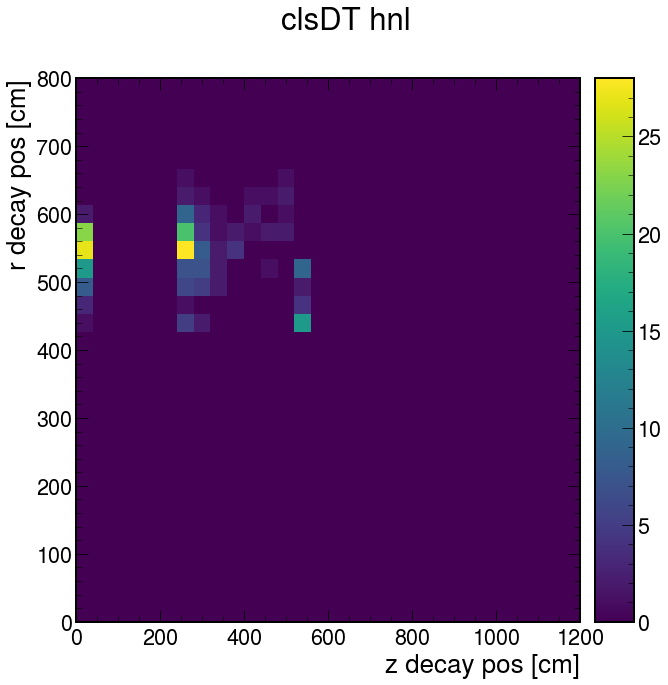

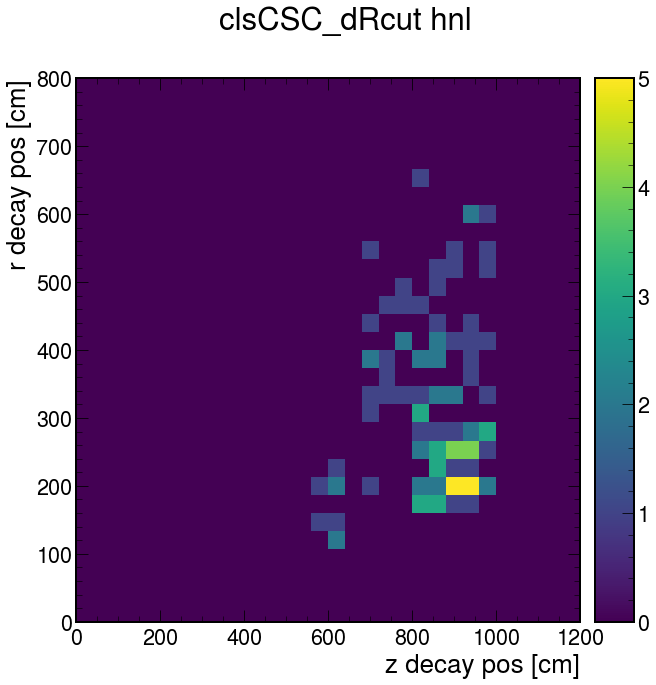

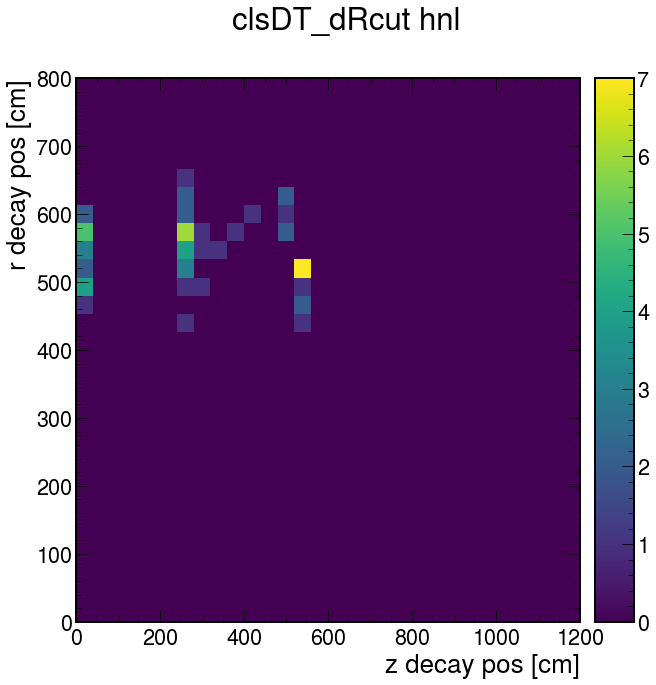

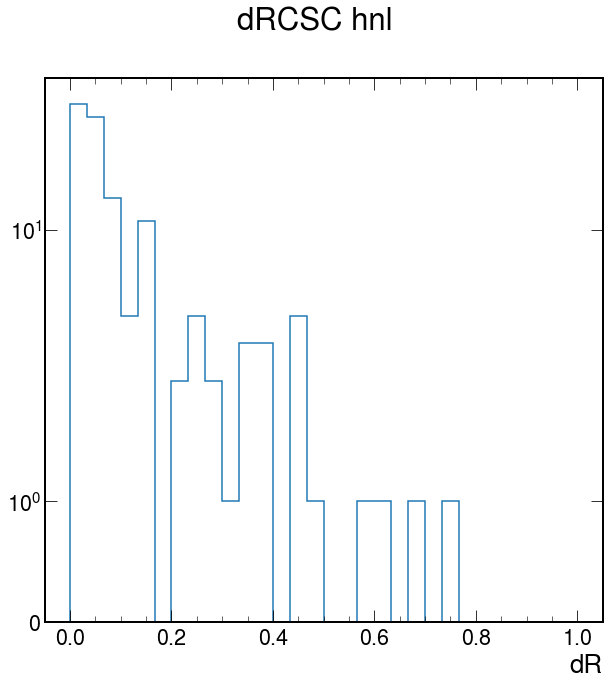

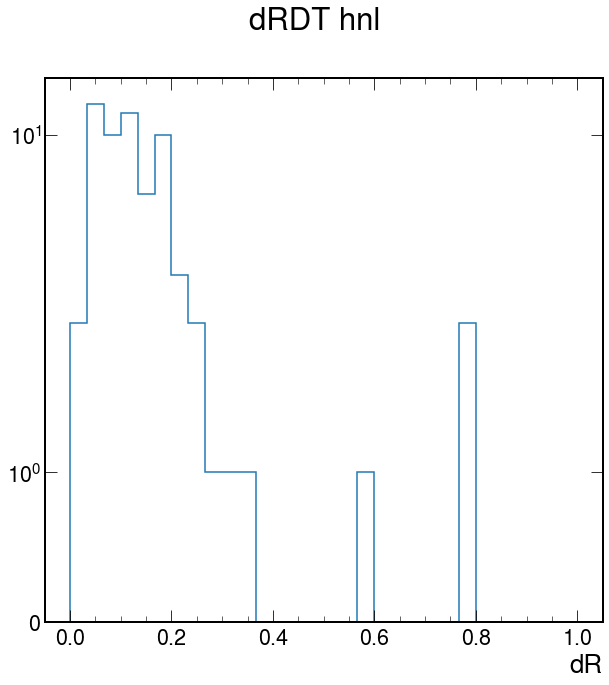

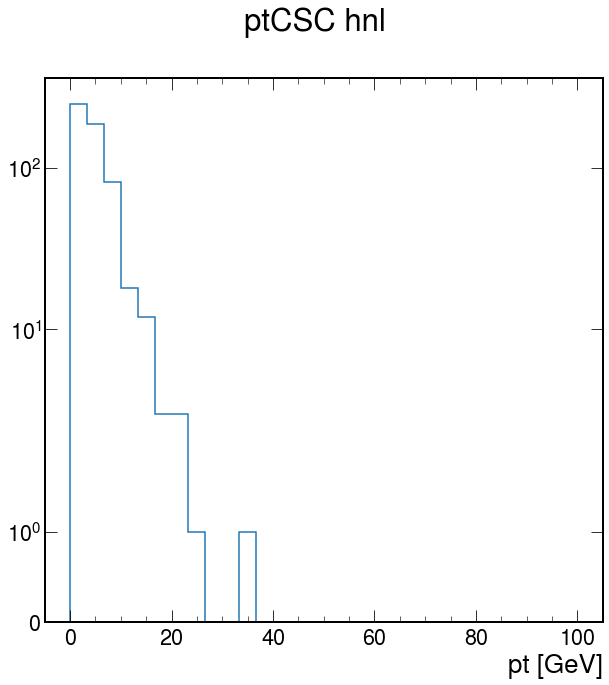

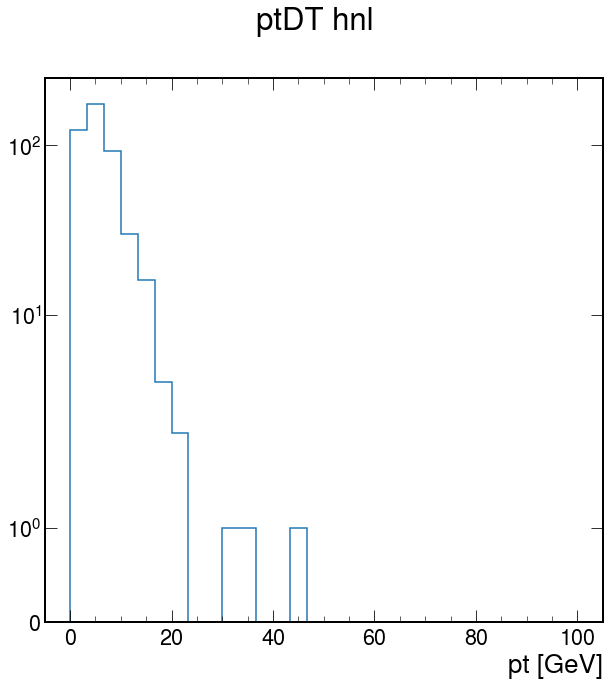

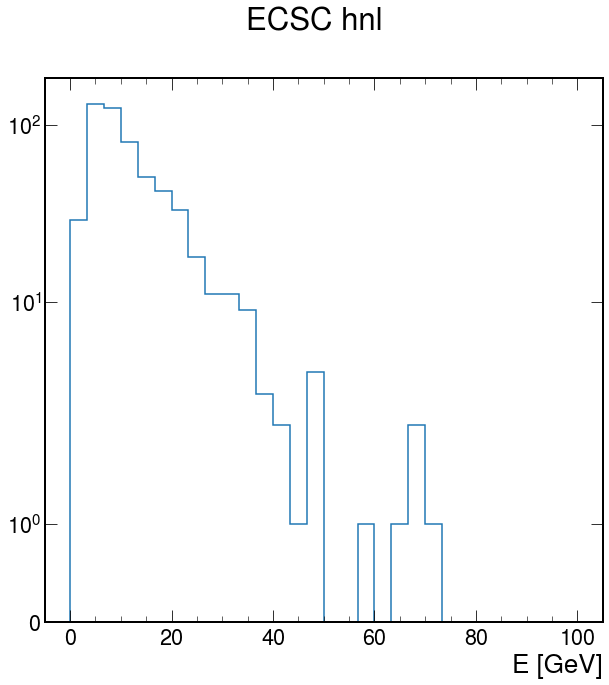

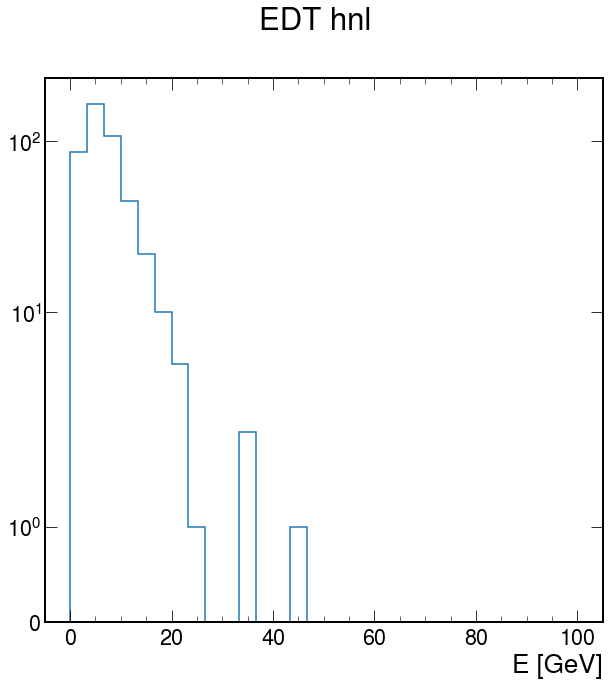

In [49]:
hep.style.use("CMS")
for junk in out:
    for jazz in out[junk]:
        if isinstance(out[junk][jazz], hist.Hist):
            fig, ax = plt.subplots()
            try:
                hep.hist2dplot(out[junk][jazz])
            except:
                hep.histplot(out[junk][jazz])
                ax.set_yscale('symlog')
            fig.suptitle(f'{jazz} {junk}')

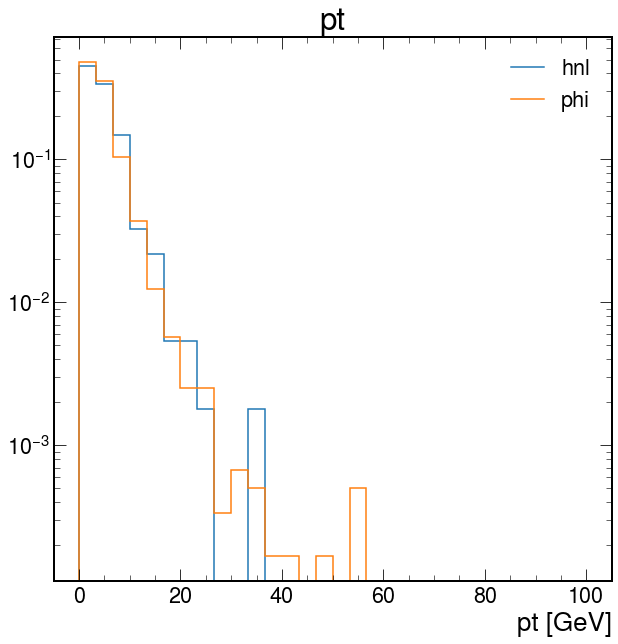

In [73]:
fig, ax = plt.subplots()
hep.histplot(out['hnl']['ptCSC'], label = 'hnl', density = True) 
hep.histplot(out['phi']['ptCSC'], label = 'phi', density = True)
ax.set_yscale('log')
ax.set_xlabel('pt [GeV]')
ax.set_title('pt')
plt.legend()
plt.show()

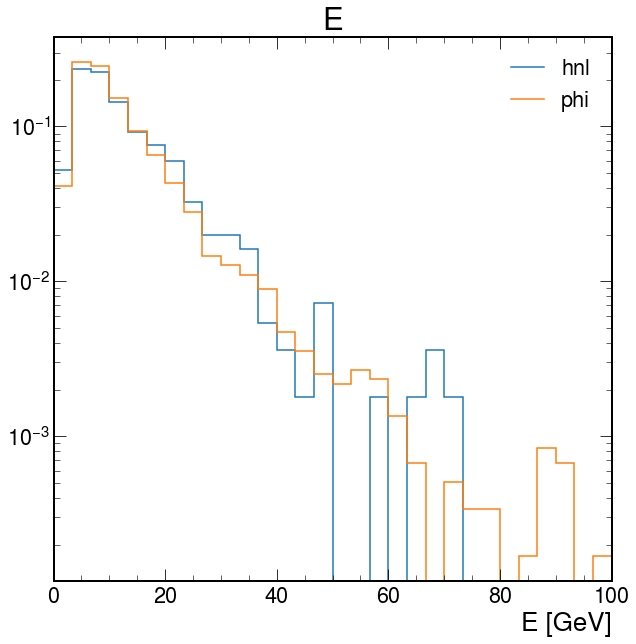

In [74]:
fig, ax = plt.subplots()
ax.set_xlim([0,100])
hep.histplot(out['hnl']['ECSC'], label = 'hnl', density = True) 
hep.histplot(out['phi']['ECSC'], label = 'phi', density = True)
ax.set_yscale('log')
ax.set_xlabel('E [GeV]')
ax.set_title('E')
plt.legend()
plt.show()

In [ ]:
import mplhep
from hist.intervals import ratio_uncertainty
import matplotlib.patches as patches

plt.style.use(mplhep.style.CMS)


def ratio(reco, real, rax, ax, det):
    num = reco.project(ax)
    den = real.project(ax)
    rax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view(), "poisson"),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    rax.set_ylabel(f"{det} Cluster Efficiency")
    rax.set_xlabel(f"LLP decay {ax}[cm]")
    return rax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(550,1075)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax

def drawCSCr(ax):
    y_max = ax.get_ylim()[1]
    ax.axvline(350,linestyle="--",color='grey')
    ax.text(350-140,y_max*0.9, "Inner ring", fontsize=15)
    ax.text(350+15 ,y_max*0.9, "Outer ring", fontsize=15)
    return ax

sample = '1e3mm'
print(sample)
figsize = (18,6)
fig, (cscrax, csczax) = plt.subplots(1,2,figsize = figsize)

llp = out[sample]['genCSC']
csc = out[sample]['clsCSC']

ratio(csc, llp, csczax, 'z', 'csc')
drawCSCz(csczax)

ratio(csc, llp, cscrax, 'r', 'csc')
drawCSCr(cscrax)
fig.savefig(sample + '.pdf')

In [60]:
filename = 'root://cmsxrootd.fnal.gov//store/group/lpclonglived/displacedJetMuonNtuple/V1p17/MC_Fall18/v2/BToHNL_MuonAndHNLGenFilter_mHNL1p0_ctau1000/Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_batch1_v1/220309_174743/0000/displacedJetMuon_ntupler_100.root'
file = uproot.open(filename)
events = NanoEventsFactory.from_root(
    file,
    treepath='ntuples/llp',
    entry_stop=10000,
    metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()
events.fields[]

['isData',
 'nPV',
 'runNum',
 'nSlimmedSecondV',
 'lumiNum',
 'eventNum',
 'eventTime',
 'pvX',
 'pvY',
 'pvZ',
 'fixedGridRhoAll',
 'fixedGridRhoFastjetAll',
 'fixedGridRhoFastjetAllCalo',
 'fixedGridRhoFastjetCentralCalo',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'fixedGridRhoFastjetCentralNeutral',
 'nPVAll',
 'pvAllX',
 'pvAllY',
 'pvAllZ',
 'pvAllLogSumPtSq',
 'pvAllSumPx',
 'pvAllSumPy',
 'nBunchXing',
 'BunchXing',
 'nPU',
 'nPUmean',
 'nMuons',
 'muonE',
 'muonPt',
 'muonEta',
 'muonPhi',
 'muonCharge',
 'muonIsLoose',
 'muonIsMedium',
 'muonIsTight',
 'muon_d0',
 'muon_dZ',
 'muon_ip3d',
 'muon_ip3dSignificance',
 'muonType',
 'muonQuality',
 'muon_pileupIso',
 'muon_chargedIso',
 'muon_photonIso',
 'muon_neutralHadIso',
 'muon_ptrel',
 'muon_chargedMiniIso',
 'muon_photonAndNeutralHadronMiniIso',
 'muon_chargedPileupMiniIso',
 'muon_activityMiniIsoAnnulus',
 'muon_passSingleMuTagFilter',
 'muon_passHLTFilter',
 'muon_validFractionTrackerHits',
 'muon_isGlobal',
 'muon_no

<Array [[6.5e+03, 6.5e+03, ... 2.01e-05, 1.87]] type='319 * var * float32[parame...'>